In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
from time import time
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from keras.utils.vis_utils import plot_model

In [3]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.applications.vgg16 import preprocess_input as vgg16_preproc
from skimage.transform import resize
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from glob import glob
import os
from itertools import chain
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import math
import sklearn.model_selection as skl

In [4]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename):
    ds = pydicom.dcmread(filename)
    # Modality
    if not ds.Modality == 'DX':
        print('Load file {}...'.format(filename))
        print(f'Image rejected. Reason: modality is not DX, modality {ds.Modality}.\n')
        return None, ds.StudyDescription
    # Patient Position
    elif ds.PatientPosition not in ['AP', 'PA']:
        print('Load file {} ...'.format(filename))
        print(f'Image rejected. Reason: position is not AP or PA, position {ds.PatientPosition}.\n' )
        return None, ds.StudyDescription
    # Body Part
    elif ds.BodyPartExamined != 'CHEST':
        print('Load file {} ...'.format(filename))
        print(f'Image rejected. Reason: body part Body part is not Chest, body part is {ds.BodyPartExamined}\n')
        return None, ds.StudyDescription
    
    else:
        img = ds.pixel_array
        print('Load file : {}'.format(filename))
        plt.imshow(img)
        plt.show()
    return img, ds.StudyDescription
    # todo
    
#     print('Load file {} ...'.format(filename))
#     ds = pydicom.dcmread(filename)       
#     img = ds.pixel_array
    #return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
#def preprocess_image(img,img_size): 
#def preprocess_image(img,img_mean,img_std,img_size, verbose=False): 
#    # todo
#    scaled_img=img/255.0 
#    standardized_img=(scaled_img-np.mean(scaled_img))/np.std(scaled_img)
#    resized_img = resize(standardized_img, (img_size[1], img_size[2]))
#    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
#    proc_img = np.repeat(proc_img, img_size[3], axis=3)
#    return proc_img

def preprocess_image(img, img_mean, img_std, img_size): 
    
    if len(img.shape) == 3:
        img = color.rgb2gray(img)
        
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)

    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)


    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # todo
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(weight_path)
    print("Loaded model", loaded_model, "from disk.")
    return loaded_model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo
        
    prediction_pro = model.predict(img)
    print("prediction", prediction_pro)
    if prediction_pro>=thresh:
        prediction=1
    else:
        prediction=0
    return prediction 

Loaded model <keras.engine.sequential.Sequential object at 0x7f3aeb81cd50> from disk.
Load file : test1.dcm


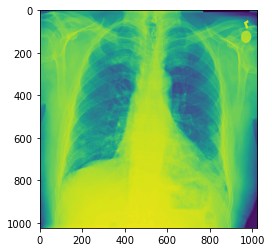

prediction [[0.08433995]]
Prediction: No pneumonia
Actual: No Finding

Load file : test2.dcm


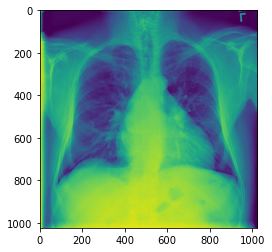

prediction [[0.11011503]]
Prediction: No pneumonia
Actual: Cardiomegaly

Load file : test3.dcm


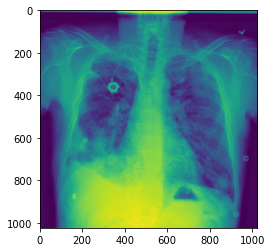

prediction [[0.35404053]]
Prediction: No pneumonia
Actual: Effusion

Load file test4.dcm ...
Image rejected. Reason: body part Body part is not Chest, body part is RIBCAGE

Load file test5.dcm...
Image rejected. Reason: modality is not DX, modality CT.

Load file test6.dcm ...
Image rejected. Reason: position is not AP or PA, position XX.



In [5]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'xray_final_model3.json'
weight_path = 'xray_classification_model3.best.hdf5'

#model_path = 'my_model.json'#path to saved model
#weight_path = 'xray_class_my_model1.best.hdf5'#path to saved best weights

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = -1 # loads the mean image value they used during training preprocessing
img_std = -1 # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.539#loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img, study_description = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    #img_proc = preprocess_image(img,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    #print(pred)
    print(f'Prediction: {"No pneumonia" if pred == False else "Pneumonia"}')
    print(f'Actual: {study_description}\n')

In [6]:
pydicom.dcmread('test1.dcm').BodyPartExamined

'CHEST'

In [7]:
pydicom.dcmread('test6.dcm').PatientPosition

'XX'

# Labels

In [8]:
pydicom.dcmread('test1.dcm').StudyDescription

'No Finding'

In [9]:
pydicom.dcmread('test2.dcm').StudyDescription

'Cardiomegaly'

In [10]:
pydicom.dcmread('test3.dcm').StudyDescription

'Effusion'

In [11]:
pydicom.dcmread('test3.dcm')

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.179222148351666120521423991179194552820263
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'Effusion'
(0010, 0020) Patient ID                          LO: '61'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '77'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'AP'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.189886800072183603320722059194952488628637
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.110145974268321300517474523922373370343198
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows        

In [12]:
pydicom.dcmread('test4.dcm').StudyDescription

'No Finding'

In [13]:
pydicom.dcmread('test5.dcm').StudyDescription

'No Finding'

In [14]:
pydicom.dcmread('test6.dcm').StudyDescription

'No Finding'

In [15]:
#plot_model(my_model, to_file='images/model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
96671,00025473_007.png,Infiltration|Mass,7,25473,24,F,PA,2402,2774,0.143,0.143,NaN,/data/images_011/images/00025473_007.png
39933,00010433_008.png,No Finding,8,10433,21,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010433_008.png
66821,00016508_062.png,No Finding,62,16508,52,F,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00016508_062.png


In [17]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for label in all_labels:
    if len(label) > 1: #do not add empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
print('Clean Labels ({})'.format(len(all_labels)), 
      [(label,int(all_xray_df[label].sum())) for label in all_labels])    
all_xray_df.head()

Clean Labels (14) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#all_xray_df2 = all_xray_df.head(10000)

In [19]:
#for finding in all_xray_df2:
#    all_xray_df2[finding] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

#all_xray_df.head()

In [20]:
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [21]:
test_df, test_df2 = skl.train_test_split(all_xray_df, test_size = 0.5, stratify = all_xray_df['pneumonia_class'])

In [22]:
len(test_df)

56060

In [23]:
#Correct training set to contain equal number of positive and negative cases
#obtain index
train_pos_inds = test_df[test_df['pneumonia_class'] == 'Y'].index.tolist()
train_neg_inds = test_df[test_df['pneumonia_class'] == 'N'].index.tolist()
#use sample to choose len(train_pos_inds) unique random elements from a population sequence or set
train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
test_df = test_df.loc[train_pos_inds + train_neg_sample]

In [24]:
len(test_df)

1430

In [25]:
test_df_ratio = len(test_df[test_df['pneumonia_class'] == 'Y'])/len(test_df)

In [26]:
print(f'pneumonia: {100.0 * test_df_ratio :.2f}%')

pneumonia: 50.00%


In [27]:
test_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
109703,00029843_001.png,Atelectasis|Effusion|Pneumonia,1,29843,53,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Y
4587,00001247_011.png,Pneumonia,11,1247,44,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Y
100235,00026560_010.png,Cardiomegaly|Consolidation|Pneumonia,10,26560,46,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Y
65743,00016231_002.png,Atelectasis|Pneumonia,2,16231,42,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Y
48430,00012280_002.png,Edema|Pneumonia,2,12280,53,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Y


In [28]:
def predict_image_prob(model, img): 
    return model.predict(img)[0][0]


def predict_valid(row):
    ind = row.name
    path = row['path']
    
    s = time()
    img_data = image.imread(path)
    img_prep = preprocess_image(img_data, -1, -1, IMG_SIZE)
    time_load = int((time() - s)*1000000)
    
    s = time()
    result = predict_image_prob(my_model, img_prep)
    time_predict = int((time() - s)*1000000)

    if int(ind) % 100 == 0:
        print(f'[{ind}] Processed {path}, result: {result :.5f}', flush=True)

    return pd.Series([result, time_load, time_predict])

In [29]:
test_df[['pneumonia_pred', 'time_load', 'time_pred']] = test_df.apply(lambda x: predict_valid(x), axis=1)

[103200] Processed /data/images_011/images/00027508_001.png, result: 0.12296
[71200] Processed /data/images_008/images/00017549_002.png, result: 0.16618
[8700] Processed /data/images_002/images/00002300_008.png, result: 0.16519
[56100] Processed /data/images_007/images/00013997_000.png, result: 0.16991
[71100] Processed /data/images_008/images/00017528_014.png, result: 0.22857
[107500] Processed /data/images_012/images/00029039_010.png, result: 0.17389
[27900] Processed /data/images_004/images/00007272_000.png, result: 0.09928
[52100] Processed /data/images_006/images/00013140_003.png, result: 0.14584
[69100] Processed /data/images_008/images/00017049_006.png, result: 0.13792
[36900] Processed /data/images_005/images/00009720_000.png, result: 0.08455
[86800] Processed /data/images_010/images/00021414_002.png, result: 0.14416
[23900] Processed /data/images_003/images/00006298_000.png, result: 0.09985


In [30]:
test_df.shape

(1430, 31)

In [31]:
test_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,pneumonia_pred,time_load,time_pred
109703,00029843_001.png,Atelectasis|Effusion|Pneumonia,1,29843,53,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,Y,0.098877,33582.0,25693.0
4587,00001247_011.png,Pneumonia,11,1247,44,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,Y,0.083055,36682.0,25467.0
100235,00026560_010.png,Cardiomegaly|Consolidation|Pneumonia,10,26560,46,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,Y,0.095271,33897.0,25775.0
65743,00016231_002.png,Atelectasis|Pneumonia,2,16231,42,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,Y,0.320413,35637.0,25387.0
48430,00012280_002.png,Edema|Pneumonia,2,12280,53,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,Y,0.216012,34830.0,25086.0


In [32]:
y = test_df.Pneumonia
y_pred = test_df.pneumonia_pred

In [33]:
def plot_auc(t_y, p_y):
    f, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('bmh')
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR',fontsize=12)
    plt.ylabel('TPR',fontsize=12)
    plt.title('ROC Curve',fontsize=15)  
    plt.show()
    
def calc_f1(prec,recall):
    f1score = 2*(prec*recall)/(prec+recall)
    if not math.isnan(f1score):
        return f1score
    else: 
        return 0

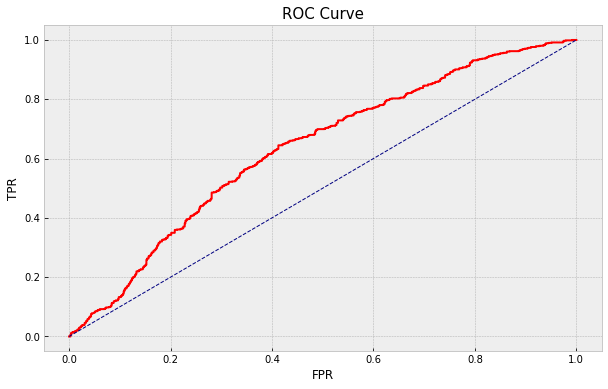

In [44]:
plot_auc(y, y_pred)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


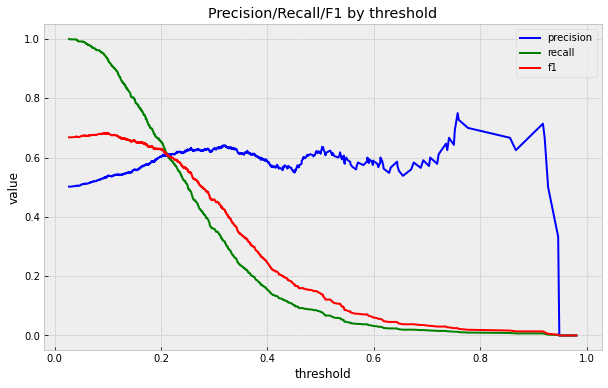

In [35]:
precision, recall, thresholds = precision_recall_curve(y, y_pred, pos_label=1)
f1scores = [calc_f1(precision[i], recall[i]) for i in range(len(thresholds))]

f, ax = plt.subplots(figsize=(10, 6))
plt.style.use('bmh')
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, color='red', lw=2, label='f1')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall/F1 by threshold')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


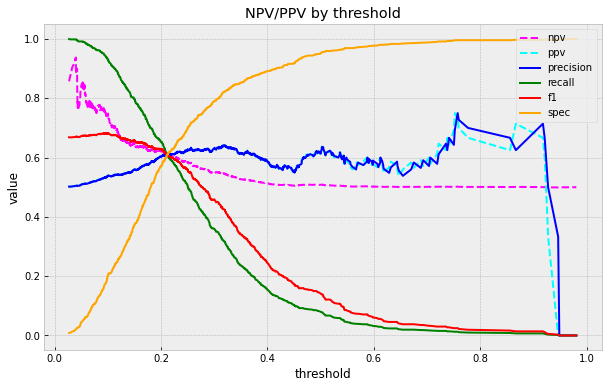

In [36]:
npv = []
ppv = []
spec = []

for th in thresholds:
    tn, fp, fn, tp = confusion_matrix(y, (y_pred > th).astype(int)).ravel()
    npv.append(tn / (tn + fn))
    ppv.append(tp / (tp + fp))
    spec.append(tn / (tn + fp))

f, ax = plt.subplots(figsize=(10, 6))
plt.style.use('bmh')
plt.plot(thresholds, npv, color='magenta', lw=2, label='npv', linestyle='--')
plt.plot(thresholds, ppv, color='cyan', lw=2, label='ppv', linestyle='--')
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, color='red', lw=2, label='f1')
plt.plot(thresholds, spec, color='orange', lw=2, label='spec')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('NPV/PPV by threshold')
plt.show()

In [37]:
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}, specificity: {spec[ind] :.3f}')

Max F1 score: 0.683, threshold: 0.100, precision: 0.539, recall: 0.931, specificity: 0.204


In [38]:
for i in range(10,1430,50): 
    ind = np.argmax(np.array(f1scores[:i], dtype=np.float32))
    f1 = f1scores[ind]
    print(f'[{ind}] F1: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}, specificity: {spec[ind] :.3f}, npv: {npv[ind] :.3f}')

[9] F1: 0.670, threshold: 0.040, precision: 0.505, recall: 0.999, specificity: 0.021, npv: 0.938
[45] F1: 0.675, threshold: 0.057, precision: 0.513, recall: 0.989, specificity: 0.060, npv: 0.827
[109] F1: 0.678, threshold: 0.080, precision: 0.523, recall: 0.962, specificity: 0.124, npv: 0.767
[156] F1: 0.682, threshold: 0.094, precision: 0.533, recall: 0.945, specificity: 0.172, npv: 0.755
[189] F1: 0.683, threshold: 0.100, precision: 0.539, recall: 0.931, specificity: 0.204, npv: 0.745
[189] F1: 0.683, threshold: 0.100, precision: 0.539, recall: 0.931, specificity: 0.204, npv: 0.745
[189] F1: 0.683, threshold: 0.100, precision: 0.539, recall: 0.931, specificity: 0.204, npv: 0.745
[189] F1: 0.683, threshold: 0.100, precision: 0.539, recall: 0.931, specificity: 0.204, npv: 0.745
[189] F1: 0.683, threshold: 0.100, precision: 0.539, recall: 0.931, specificity: 0.204, npv: 0.745
[189] F1: 0.683, threshold: 0.100, precision: 0.539, recall: 0.931, specificity: 0.204, npv: 0.745
[189] F1: 0.6

In [39]:
thresholds[240]

0.11446742713451385

In [40]:
test_df['pneumonia_pred_th'] = test_df.apply(lambda x: int(x['pneumonia_pred'] > thresholds[525]), axis=1)
test_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,pneumonia_pred,time_load,time_pred,pneumonia_pred_th
109703,00029843_001.png,Atelectasis|Effusion|Pneumonia,1,29843,53,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,Y,0.098877,33582.0,25693.0,0
4587,00001247_011.png,Pneumonia,11,1247,44,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,Y,0.083055,36682.0,25467.0,0
100235,00026560_010.png,Cardiomegaly|Consolidation|Pneumonia,10,26560,46,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,Y,0.095271,33897.0,25775.0,0


In [41]:
findings = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']
for i in findings:
    tn, fp, fn, tp = confusion_matrix(
        test_df[test_df[i]==1].Pneumonia.values,
        test_df[test_df[i]==1].pneumonia_pred_th.values,labels=[1,0]).ravel()
    
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    npvl = tn/(tn+fn)

    print(f'{i}: \nSensitivity (recall): {sens :.3f}, Specificity: {spec :.3f}, NPV: {npvl :.3f} \n')

Atelectasis: 
Sensitivity (recall): 0.426, Specificity: 0.662, NPV: 0.698 

Cardiomegaly: 
Sensitivity (recall): 0.462, Specificity: 0.792, NPV: 0.731 

Consolidation: 
Sensitivity (recall): 0.394, Specificity: 0.812, NPV: 0.722 

Edema: 
Sensitivity (recall): 0.077, Specificity: 0.855, NPV: 0.932 

Effusion: 
Sensitivity (recall): 0.390, Specificity: 0.748, NPV: 0.676 

Emphysema: 
Sensitivity (recall): 0.474, Specificity: 0.750, NPV: 0.474 

Fibrosis: 
Sensitivity (recall): 0.571, Specificity: 0.500, NPV: 0.143 

Hernia: 
Sensitivity (recall): 1.000, Specificity: nan, NPV: nan 

Infiltration: 
Sensitivity (recall): 0.319, Specificity: 0.780, NPV: 0.746 

Mass: 
Sensitivity (recall): 0.395, Specificity: 0.675, NPV: 0.509 

Nodule: 
Sensitivity (recall): 0.477, Specificity: 0.632, NPV: 0.511 

Pleural_Thickening: 
Sensitivity (recall): 0.500, Specificity: 0.708, NPV: 0.607 

Pneumothorax: 
Sensitivity (recall): 0.471, Specificity: 0.789, NPV: 0.455 



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [42]:
test_df[['time_load', 'time_pred']].describe()

,time_load,time_pred
count,1430.000000,1430.000000
mean,37781.288112,32040.751748
std,5692.352652,4574.327939
min,27802.000000,24950.000000
25%,35194.750000,26326.500000
50%,37298.000000,34858.500000
75%,39576.500000,35543.500000
max,197849.000000,41632.000000


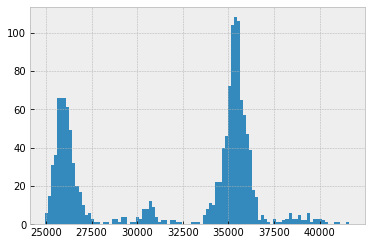

In [43]:
plt.hist(test_df['time_pred'], bins=100)
plt.show()

-    Average image pre-processing time: 40 ms, max: 89 ms
-    Average inference time: 350 milliseconds, max: 445 ms